In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Datasets and DataLoaders

In [ ]:
import os, torch, shutil, numpy as np
from glob import glob; from PIL import Image
from torch.utils.data import random_split, Dataset, DataLoader
from torchvision import transforms as T
torch.manual_seed(2024)

class CustomDataset(Dataset):

    def __init__(self, root, transformations = None):

        self.transformations = transformations
        self.im_paths = [im_path for im_path in sorted(glob(f"{root}/*/*"))]

        self.cls_names, self.cls_counts, count, data_count = {}, {}, 0, 0
        for idx, im_path in enumerate(self.im_paths):
            class_name = self.get_class(im_path)
            if class_name not in self.cls_names: self.cls_names[class_name] = count; self.cls_counts[class_name] = 1; count += 1
            else: self.cls_counts[class_name] += 1

    def get_class(self, path): return os.path.dirname(path).split("/")[-1]

    def __len__(self): return len(self.im_paths)

    def __getitem__(self, idx):

        im_path = self.im_paths[idx]
        im = Image.open(im_path).convert("RGB")
        gt = self.cls_names[self.get_class(im_path)]

        if self.transformations is not None: im = self.transformations(im)

        return im, gt

def get_dls(root, transformations, bs, split = [0.9, 0.05, 0.05], ns = 4):

    ds = CustomDataset(root = root, transformations = transformations)

    total_len = len(ds)
    tr_len = int(total_len * split[0])
    vl_len = int(total_len * split[1])
    ts_len = total_len - (tr_len + vl_len)

    tr_ds, vl_ds, ts_ds = random_split(dataset = ds, lengths = [tr_len, vl_len, ts_len])

    tr_dl, val_dl, ts_dl = DataLoader(tr_ds, batch_size = bs, shuffle = True, num_workers = ns), DataLoader(vl_ds, batch_size = bs, shuffle = False, num_workers = ns), DataLoader(ts_ds, batch_size = 1, shuffle = False, num_workers = ns)

    return tr_dl, val_dl, ts_dl, ds.cls_names


root = "/content/drive/MyDrive/dataset2/dataset2"
mean, std, im_size = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225], 224
tfs = T.Compose([T.Resize((im_size, im_size)), T.ToTensor(), T.Normalize(mean = mean, std = std)])
tr_dl, val_dl, ts_dl, classes = get_dls(root = root, transformations = tfs, bs = 32)

print(len(tr_dl)); print(len(val_dl)); print(len(ts_dl)); print(classes)

42
3
75
{'Amanita phalloides (Death Cap)': 0, 'Amanita virosa (Destroying Angels)': 1, 'Auricularia auricula-judae (kuping)': 2, 'Flammulina filiformis (enoki)': 3, 'Galerina marginata (Autumn Skullcap)': 4, 'Grifola frondosa (Maitake)': 5, 'Gyromitra esculenta (False Morel)': 6, 'Lentinula edodes (shitake)': 7, 'Tuber melanosporum (truffle)': 8}


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Data Visualization ( PCVK )

In [ ]:
import random
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image, ImageFilter
from torchvision import transforms as T
import cv2  # Import OpenCV for morphology operations

# Define the augmentation pipeline
augmentation_pipeline = T.Compose([
    T.RandomHorizontalFlip(),           # Random horizontal flip
    T.RandomVerticalFlip(),             # Random vertical flip
    T.RandomRotation(30),               # Random rotation (up to 30 degrees)
    T.RandomResizedCrop(224),           # Random crop to 224x224
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2), # Random color jitter
])

def tensor_2_im(t, t_type="rgb"):
    # Define the normalization transformations
    gray_tfs = T.Compose([T.Normalize(mean=[0.], std=[1/0.5]), T.Normalize(mean=[-0.5], std=[1])])
    rgb_tfs = T.Compose([T.Normalize(mean=[0., 0., 0.], std=[1/0.229, 1/0.224, 1/0.225]),
                         T.Normalize(mean=[-0.485, -0.456, -0.406], std=[1., 1., 1.])])

    invTrans = gray_tfs if t_type == "gray" else rgb_tfs
    # Apply inverse normalization and convert to numpy array
    img = (invTrans(t).clamp(0, 1) * 255).detach().squeeze().cpu().permute(1, 2, 0).numpy().astype(np.uint8)
    return img

def apply_morphology(image_array):
    """
    Apply dilation and erosion to the image.
    """
    # Convert RGB to grayscale for morphology
    gray_image = cv2.cvtColor(image_array, cv2.COLOR_RGB2GRAY)

    # Define a kernel for morphological operations
    kernel = np.ones((5, 5), np.uint8)

    # Apply dilation
    dilated_image = cv2.dilate(gray_image, kernel, iterations=1)

    # Apply erosion
    eroded_image = cv2.erode(gray_image, kernel, iterations=1)

    return dilated_image, eroded_image

def augment_and_sharpen(image_array):
    # Convert numpy array to PIL Image for augmentations
    pil_img = Image.fromarray(image_array)
    # Apply the augmentation pipeline
    tensor_img = T.ToTensor()(pil_img)  # Convert back to tensor for augmentation
    augmented_img = augmentation_pipeline(tensor_img)
    pil_augmented_img = T.ToPILImage()(augmented_img)
    # Apply sharpening
    sharpened_img = pil_augmented_img.filter(ImageFilter.SHARPEN)
    return np.array(sharpened_img)

def visualize(data, n_ims, rows, cmap=None, cls_names=None):
    # Ensure n_ims is divisible by rows
    assert n_ims % rows == 0, "n_ims must be divisible by rows."
    assert cmap in [None, "rgb", "gray"], "cmap must be 'rgb', 'gray', or None!"

    plt.figure(figsize=(20, 10))
    indices = [random.randint(0, len(data) - 1) for _ in range(n_ims)]
    for idx, index in enumerate(indices):
        im, gt = data[index]
        plt.subplot(rows, n_ims // rows, idx + 1)
        image_array = tensor_2_im(im, cmap)

        # Apply dilation and erosion
        dilated, eroded = apply_morphology(image_array)

        # Display the original, dilated, and eroded images
        if idx % 3 == 0:  # Original
            plt.imshow(image_array, cmap='gray' if cmap == "gray" else None)
            plt.title("Original")
        elif idx % 3 == 1:  # Dilated
            plt.imshow(dilated, cmap='gray')
            plt.title("Dilated")
        else:  # Eroded
            plt.imshow(eroded, cmap='gray')
            plt.title("Eroded")

        plt.axis('off')

# Example usage (ensure that tr_dl.dataset and classes are defined)
# visualize(tr_dl.dataset, 20, 4, cmap="rgb", cls_names=list(classes.keys()))


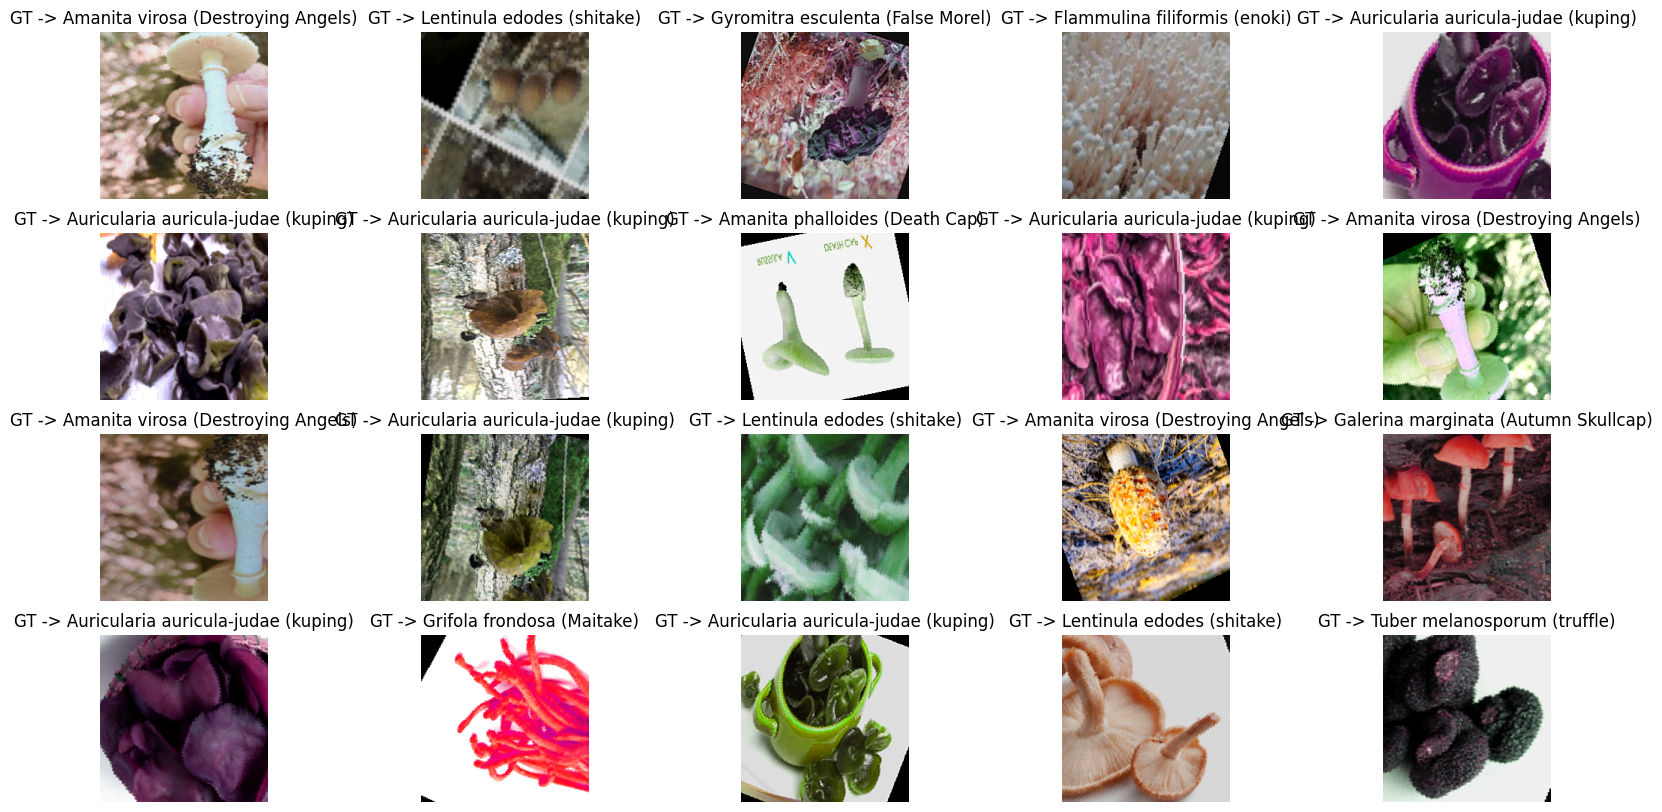

In [ ]:
visualize(val_dl.dataset, 20, 4, "rgb", list(classes.keys()))

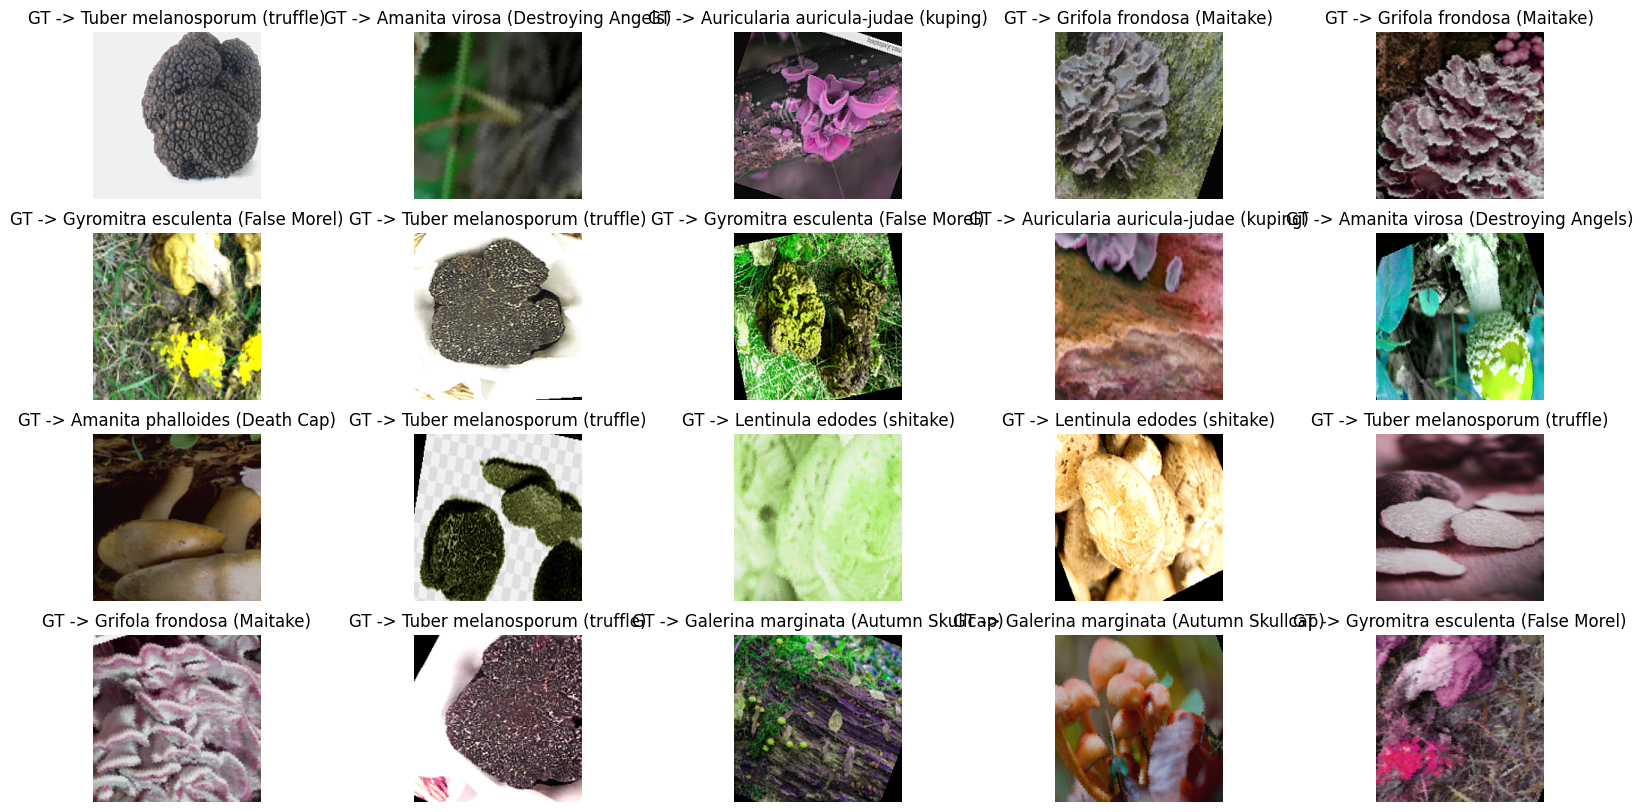

In [ ]:
visualize(ts_dl.dataset, 20, 4, "rgb", list(classes.keys()))

Data Analysis

<ipython-input-14-ff1e220b703f>:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(cls_names, rotation = 60)


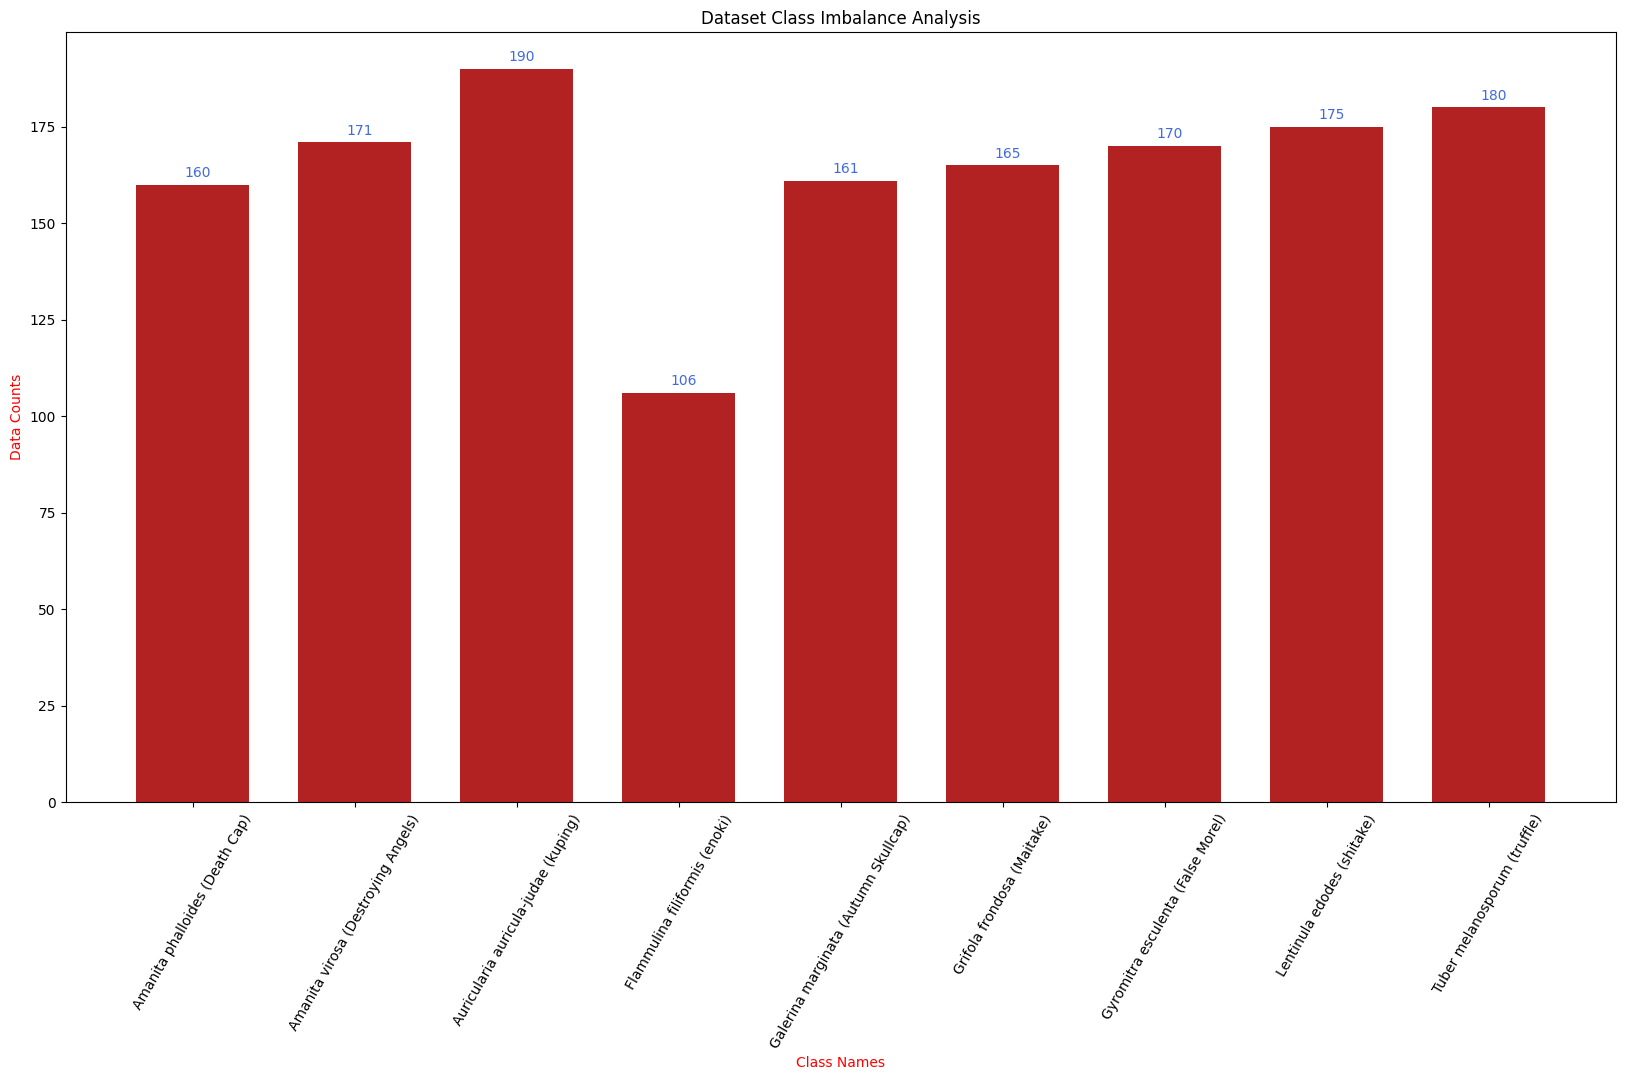

In [ ]:
def data_analysis(root, transformations):

    ds = CustomDataset(root = root, transformations = transformations)
    cls_counts, width, text_width = ds.cls_counts,  0.7, 0.05
    text_height = 2
    cls_names = list(cls_counts.keys()); counts = list(cls_counts.values())

    fig, ax = plt.subplots(figsize = (20, 10))
    indices = np.arange(len(counts))

    ax.bar(indices, counts, width, color = "firebrick")
    ax.set_xlabel("Class Names", color = "red")
    ax.set_xticklabels(cls_names, rotation = 60)
    ax.set(xticks = indices, xticklabels = cls_names)
    ax.set_ylabel("Data Counts", color = "red")
    ax.set_title(f"Dataset Class Imbalance Analysis")

    for i, v in enumerate(counts): ax.text(i - text_width, v + text_height, str(v), color = "royalblue")

data_analysis(root = root, transformations = tfs)

Train and Validation

In [ ]:
import timm
from tqdm import tqdm
import torch
import os

# Create model
m = timm.create_model("rexnet_150", pretrained=True, num_classes=len(classes))

# Function to set up training with appropriate device
def train_setup(m):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    m = m.to(device).eval()
    loss_fn = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(params=m.parameters(), lr=3e-4)
    return m, 20, device, loss_fn, optimizer

# Move batch to the device
def to_device(batch, device):
    return batch[0].to(device), batch[1].to(device)

# Get loss and accuracy
def get_metrics(model, ims, gts, loss_fn, epoch_loss, epoch_acc):
    preds = model(ims)
    loss = loss_fn(preds, gts)
    return loss, epoch_loss + loss.item(), epoch_acc + (torch.argmax(preds, dim=1) == gts).sum().item()

# Initialize the model and setup training
m, epochs, device, loss_fn, optimizer = train_setup(m)

# Variables for saving the model
save_prefix, save_dir = "mushrooms", "saved_models"
print("Start training...")
best_acc, best_loss, threshold, not_improved, patience = 0, float("inf"), 0.01, 0, 5
tr_losses, val_losses, tr_accs, val_accs = [], [], [], []

# Start training loop
for epoch in range(epochs):
    epoch_loss, epoch_acc = 0, 0
    m.train()

    for idx, batch in tqdm(enumerate(tr_dl)):
        ims, gts = to_device(batch, device)

        loss, epoch_loss, epoch_acc = get_metrics(m, ims, gts, loss_fn, epoch_loss, epoch_acc)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    tr_loss_to_track = epoch_loss / len(tr_dl)
    tr_acc_to_track = epoch_acc / len(tr_dl.dataset)
    tr_losses.append(tr_loss_to_track)
    tr_accs.append(tr_acc_to_track)

    print(f"{epoch + 1}-epoch train process is completed!")
    print(f"{epoch + 1}-epoch train loss -> {tr_loss_to_track:.3f}")
    print(f"{epoch + 1}-epoch train accuracy -> {tr_acc_to_track:.3f}")

    # Validation phase
    m.eval()
    with torch.no_grad():
        val_epoch_loss, val_epoch_acc = 0, 0
        for idx, batch in enumerate(val_dl):
            ims, gts = to_device(batch, device)

            preds = m(ims)
            loss = loss_fn(preds, gts)
            pred_cls = torch.argmax(preds.data, dim=1)
            val_epoch_acc += (pred_cls == gts).sum().item()
            val_epoch_loss += loss.item()

        val_loss_to_track = val_epoch_loss / len(val_dl)
        val_acc_to_track = val_epoch_acc / len(val_dl.dataset)
        val_losses.append(val_loss_to_track)
        val_accs.append(val_acc_to_track)

        print(f"{epoch + 1}-epoch validation process is completed!")
        print(f"{epoch + 1}-epoch validation loss -> {val_loss_to_track:.3f}")
        print(f"{epoch + 1}-epoch validation accuracy -> {val_acc_to_track:.3f}")

        # Save the best model in .pt format
        # if val_loss_to_track < (best_loss - threshold):
        #     os.makedirs(save_dir, exist_ok=True)
        #     best_loss = val_loss_to_track
        #     torch.save(m.state_dict(), f"{save_dir}/{save_prefix}_best_model.pt")
        if val_loss_to_track < (best_loss - threshold):
          os.makedirs(save_dir, exist_ok=True)
          best_loss = val_loss_to_track
          torch.save(m.state_dict(), f"{save_dir}/{save_prefix}_best_model.pth")  # Simpan sebagai .pth
        else:
            not_improved += 1
            print(f"Loss value did not decrease for {not_improved} epochs")
            if not_improved == patience:
                print(f"Stop training since loss value did not decrease for {patience} epochs.")
                break

        # Save the best model in .pth format



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/39.2M [00:00<?, ?B/s]

Start training...


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
8it [00:45,  3.20s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
20it [01:50,  3.83s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should

1-epoch train process is completed!
1-epoch train loss -> 1.101
1-epoch train accuracy -> 0.692


1-epoch validation process is completed!
1-epoch validation loss -> 0.244
1-epoch validation accuracy -> 0.877


8it [00:04,  2.76it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
36it [00:20,  2.45it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
42it [00:23,  1.79it/s]

2-epoch train process is completed!
2-epoch train loss -> 0.099
2-epoch train accuracy -> 0.964


2-epoch validation process is completed!
2-epoch validation loss -> 0.186
2-epoch validation accuracy -> 0.877


0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
4it [00:03,  1.80it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
22it [00:14,  1.10s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
28it [00:16,  2.67it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
42it [00:22,  1.87it/s]

3-epoch train process is completed!
3-epoch train loss -> 0.071
3-epoch train accuracy -> 0.986


3-epoch validation process is completed!
3-epoch validation loss -> 0.246
3-epoch validation accuracy -> 0.877
Loss value did not decrease for 1 epochs


9it [00:08,  1.22it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
14it [00:10,  1.91it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
32it [00:20,  1.66it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
42it [00:24,  1.72it/s]

4-epoch train process is completed!
4-epoch train loss -> 0.051
4-epoch train accuracy -> 0.988


4-epoch validation process is completed!
4-epoch validation loss -> 0.261
4-epoch validation accuracy -> 0.904
Loss value did not decrease for 2 epochs


0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
9it [00:07,  1.05it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
14it [00:10,  1.53it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
32it [00:18,  2.75it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
42it [00:24,  1.73it/s]

5-epoch train process is completed!
5-epoch train loss -> 0.050
5-epoch train accuracy -> 0.988


5-epoch validation process is completed!
5-epoch validation loss -> 0.271
5-epoch validation accuracy -> 0.890
Loss value did not decrease for 3 epochs


9it [00:05,  2.16it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
13it [00:07,  2.35it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
32it [00:19,  2.32it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
42it [00:22,  1.86it/s]

6-epoch train process is completed!
6-epoch train loss -> 0.033
6-epoch train accuracy -> 0.992


6-epoch validation process is completed!
6-epoch validation loss -> 0.266
6-epoch validation accuracy -> 0.904
Loss value did not decrease for 4 epochs


0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
20it [00:11,  2.37it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
24it [00:15,  1.51it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
42it [00:22,  1.85it/s]

7-epoch train process is completed!
7-epoch train loss -> 0.036
7-epoch train accuracy -> 0.990


7-epoch validation process is completed!
7-epoch validation loss -> 0.242
7-epoch validation accuracy -> 0.877
Loss value did not decrease for 5 epochs
Stop training since loss value did not decrease for 5 epochs.


# Kode RestAPI dengan FastAPI

In [ ]:
from fastapi import FastAPI, File, UploadFile
from torchvision import transforms
from PIL import Image
import torch
import timm
import io

app = FastAPI()

# Daftar nama jamur yang sesuai dengan kelas yang digunakan dalam training
mushroom_classes = ["Amanita virosa (Destroying Angels)", "Tuber melanosporum", "Lentinula edodes", "Gyromitra esculenta", "Grifola frondosa", "Galerina marginata", "Flammulina filiformis", "Auricularia auricula", "Amanita phalloides"]  # Sesuaikan dengan datasetmu

# Load model dari file .pth
model_path = "saved_models/mushrooms_best_model.pth"
model = timm.create_model("rexnet_150", pretrained=False, num_classes=len(mushroom_classes))
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
model.eval()

# Preprocessing untuk gambar input (sesuaikan dengan yang digunakan selama training)
mean, std, im_size = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225], 224
preprocess = transforms.Compose([
    transforms.Resize((im_size, im_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

# Fungsi untuk melakukan prediksi gambar jamur
def predict_mushroom(image: Image.Image):
    image_tensor = preprocess(image).unsqueeze(0)  # Tambah batch size = 1
    with torch.no_grad():
        outputs = model(image_tensor)
        _, predicted = torch.max(outputs, 1)
        return mushroom_classes[predicted.item()]

# Endpoint untuk upload gambar dan memberikan nama jamur
@app.post("/predict/")
async def predict(file: UploadFile = File(...)):
    # Baca dan proses gambar yang di-upload
    image = Image.open(io.BytesIO(await file.read())).convert("RGB")
    mushroom_name = predict_mushroom(image)  # Prediksi nama jamur
    return {"mushroom_name": mushroom_name}

if __name__ == "__main__":
    import uvicorn
    uvicorn.run(app, host="0.0.0.0", port=8000)

ModuleNotFoundError: No module named 'fastapi'